## Importing Libraries

In [25]:
import os
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
from scipy.spatial import distance

from cv2 import ORB_create

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from skimage import exposure
from matplotlib.colors import Normalize

# Loading Data

In [26]:
# Image Directory
img_dir = "data/"

# Data Groups
grps = ["train", "test"]

# Initializing a Dataframe to store paths and labels
column_names = ["grp", "path", "label", "label_int", "filename"]
data = pd.DataFrame(columns = column_names)

# Class Labels
class_names = []

for path in sorted([f for f in os.listdir(img_dir) if not f.startswith('.')]):
    # Get class name
    class_names.append(path)
    
    # Get all train images in the class
    with open(img_dir + path + "/train.txt") as f:
        for line in f:
            row = pd.DataFrame({'grp': ['train'], 
                                'path': [os.path.join(img_dir, path, line.strip())], 
                                'label': [path], 
                                'label_int': [class_names.index(path)], 
                                'filename': [line.strip()]})
            data = pd.concat([data, row], ignore_index=True, axis=0)

    # Get all test images in the class
    with open(img_dir + path + "/test.txt") as f:
        for line in f:
            row = pd.DataFrame({'grp': ['test'], 
                                'path': [os.path.join(img_dir, path, line.strip())], 
                                'label': [path], 
                                'label_int': [class_names.index(path)], 
                                'filename': [line.strip()]})
            data = pd.concat([data, row], ignore_index=True, axis=0)

# Printing Useful information
print("Data Shape: ", data.shape)
print("Labels: ", data.label.unique(),  data.label_int.unique())

print("Dataset:")
data.head(8)

Data Shape:  (1000, 5)
Labels:  ['00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008' '00009'
 '00010'] [0 1 2 3 4 5 6 7 8 9]
Dataset:


,grp,path,label,label_int,filename
0,train,data/00001/00468_00002.ppm,00001,0,00468_00002.ppm
1,train,data/00001/00475_00000.ppm,00001,0,00475_00000.ppm
2,train,data/00001/00475_00001.ppm,00001,0,00475_00001.ppm
3,train,data/00001/00475_00002.ppm,00001,0,00475_00002.ppm
4,train,data/00001/00801_00000.ppm,00001,0,00801_00000.ppm
5,train,data/00001/00801_00001.ppm,00001,0,00801_00001.ppm
6,train,data/00001/00801_00002.ppm,00001,0,00801_00002.ppm
7,train,data/00001/00806_00000.ppm,00001,0,00806_00000.ppm


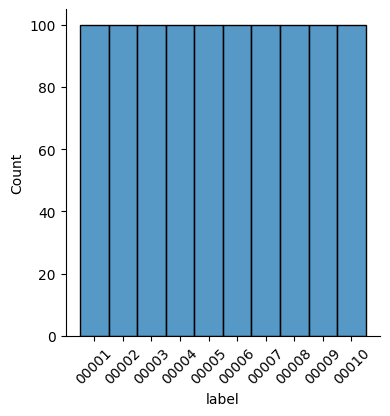

In [27]:
ax = sns.displot(data=data, x='label', height=4)
ax.set_xticklabels(rotation=45)

# Loading Images

In [28]:
img_width = 128
img_height = 128
dim = (img_width, img_height)

# Initializing images column
data['img_read'] = np.nan
data['img_read'] = data['img_read'].astype(object)

# Printing Info
print("[INFO] Importing Images")

# Iterating on all rows and reading image data
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img = cv2.imread(row.path, 0)
    img = cv2.resize(img, dim)
    data.at[index, 'img_read'] = img

[INFO] Importing Images


100%|██████████| 1000/1000 [00:00<00:00, 4558.11it/s]


# Viewing Images

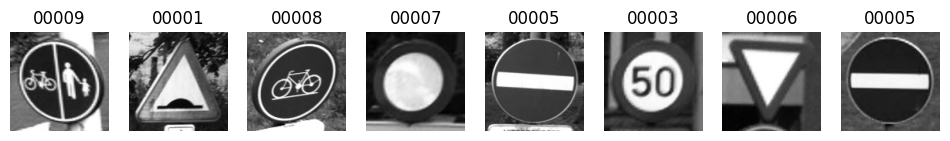

In [29]:
row = 1
col = 8

fig, axes = plt.subplots(row, col, figsize=(1.5*col,2*row))
for (index, data_sample), i in zip(data.sample(8).iterrows(), range(8)):
    ax = axes[i]
    ax.imshow(data_sample["img_read"], "gray")
    ax.set_title(data_sample.label)
    ax.axis("off") 
plt.show()

# Initialization of Feature Descriptor: 
# <span style="color:yellow"> ORB (Oriented FAST and Rotated BRIEF) Descriptor</span>

### Adjusting the parameters of ORB Descriptor

In [30]:
# Initializing ORB Detector
orb = ORB_create()

# Clusters
n_clusters = len(class_names) * 5

In [35]:
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 32)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

In [43]:
# Train Data Selection
trainData = data[(data['grp'] == "train")]
trainLabels = data[data['grp'] == "train"]["label_int"].tolist()

# Initalize ORB Descriptors
orb_descriptors = []
orb_labels = []
image_count = 0

for index, row in trainData.iterrows():
    # Getting Image Data
    img_data = row["img_read"]

    # Computing ORB Descriptors
    kp, des = orb.detectAndCompute(img_data, None)

    if(des is not None):
        image_count += 1
        orb_descriptors.append(des)
        orb_labels.append(row["label_int"])

In [44]:
# Clustering Descriptors
descriptors = np.array(orb_descriptors[0])
for descriptor in orb_descriptors[1:]:
    descriptors = np.vstack((descriptors, descriptor)) 
kmeans = KMeans(n_clusters = n_clusters).fit(descriptors)

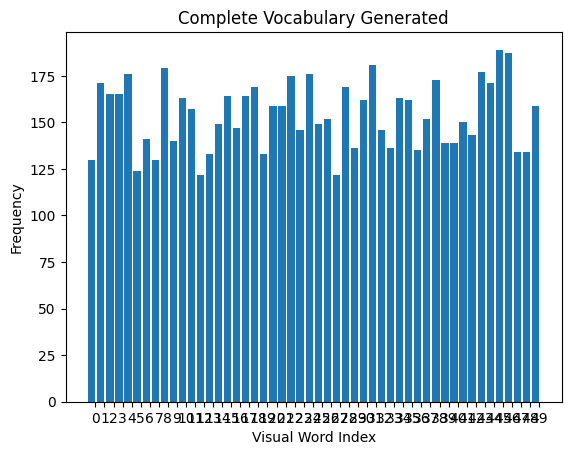

In [45]:
# Extracting Features and Normalizing
im_features = extractFeatures(kmeans, orb_descriptors, image_count, n_clusters)
scale = StandardScaler().fit(im_features)        
im_features = scale.transform(im_features)

# Plottting Histogram
x_scalar = np.arange(n_clusters)
y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(n_clusters)])

plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.title("Complete Vocabulary Generated")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

In [46]:
# Test Data Selection
testData = data[(data['grp'] == "test")]
testLabels = data[data['grp'] == "test"]["label_int"].tolist()

# Initalize ORB Descriptors
test_orb_descriptors = []
test_orb_labels = []
test_img_count = 0

for index, row in testData.iterrows():
    # Getting Image Data
    img_data = row["img_read"]

    # Computing ORB Descriptors
    kp, des = orb.detectAndCompute(img_data, None)

    if(des is not None):
        test_img_count += 1
        test_orb_descriptors.append(des)
        test_orb_labels.append(row["label_int"])

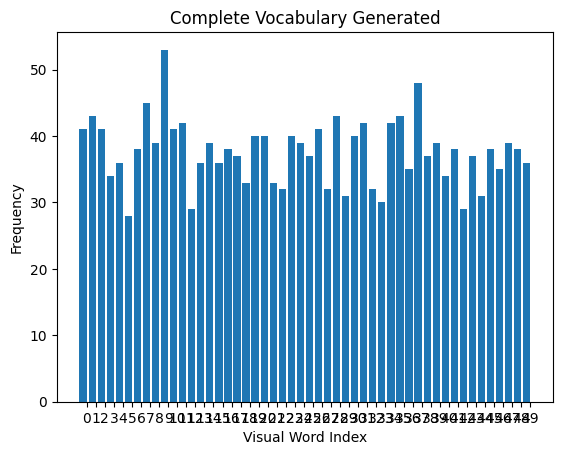

In [47]:
# Extracting Features and Normalizing
test_im_features = extractFeatures(kmeans, test_orb_descriptors, test_img_count, n_clusters)
test_scale = StandardScaler().fit(test_im_features)        
test_im_features = test_scale.transform(test_im_features)

# Plottting Histogram
x_scalar = np.arange(n_clusters)
y_scalar = np.array([abs(np.sum(test_im_features[:,h], dtype=np.int32)) for h in range(n_clusters)])

plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.title("Complete Vocabulary Generated")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

# Classification using SVM

### Train Data

In [48]:
X = np.array(np.dot(im_features, im_features.T), np.float32)
y = np.array(orb_labels)

### Model Training

In [50]:
# Defining SVM GridSearch Parameters
kernels = ['precomputed']
C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-12, 3, 5)
param_grid = dict(kernel=kernels, gamma=gamma_range, C=C_range)

# Cross Validation
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Model Fitting
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, verbose=3, n_jobs=-1)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END C=0.01, gamma=1e-12, kernel=precomputed;, score=0.726 total time=   0.0s
[CV 3/5] END C=0.01, gamma=1e-12, kernel=precomputed;, score=0.696 total time=   0.0s
[CV 4/5] END C=0.01, gamma=5.623413251903491e-09, kernel=precomputed;, score=0.689 total time=   0.0s
[CV 5/5] END C=0.01, gamma=5.623413251903491e-09, kernel=precomputed;, score=0.667 total time=   0.0s
[CV 2/5] END C=0.01, gamma=1e-12, kernel=precomputed;, score=0.748 total time=   0.0s
[CV 2/5] END C=0.01, gamma=3.1622776601683795e-05, kernel=precomputed;, score=0.748 total time=   0.0s
[CV 1/5] END C=0.01, gamma=3.1622776601683795e-05, kernel=precomputed;, score=0.726 total time=   0.0s
[CV 4/5] END C=0.01, gamma=3.1622776601683795e-05, kernel=precomputed;, score=0.689 total time=   0.0s
[CV 3/5] END C=0.01, gamma=3.1622776601683795e-05, kernel=precomputed;, score=0.696 total time=   0.0s
[CV 2/5] END C=0.01, gamma=0.1778279410038923, kernel=precompute

### Save Model

In [51]:
# Save your model or results
joblib.dump(grid, 'models/orb_svm.pkl')

['models/orb_svm.pkl']

### Load Model

In [52]:
# Load your model or results
#grid = joblib.load('models/orb_svm.pkl')

### Model Testing

In [53]:
# Predicting Test Data
testLabels_pred = grid.predict(np.dot(test_im_features, im_features.T))

In [58]:
print(classification_report(test_orb_labels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       0.71      0.85      0.77        20
       00002       0.94      0.75      0.83        20
       00003       0.83      0.95      0.88        20
       00004       1.00      1.00      1.00        20
       00005       0.00      0.00      0.00         1
       00006       0.62      0.72      0.67        18
       00007       0.70      0.58      0.64        12
       00008       1.00      0.95      0.97        20
       00009       1.00      1.00      1.00        20
       00010       0.71      0.31      0.43        16

    accuracy                           0.81       167
   macro avg       0.75      0.71      0.72       167
weighted avg       0.84      0.81      0.81       167



<AxesSubplot:>

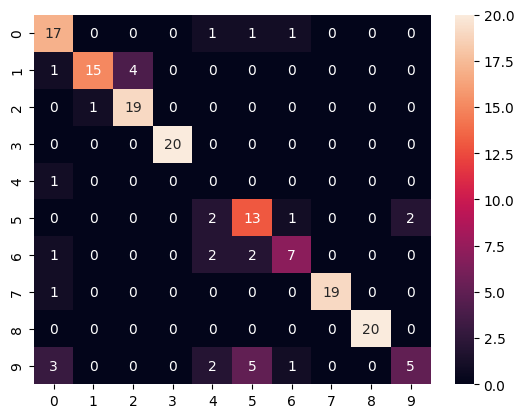

In [59]:
sns.heatmap(confusion_matrix(test_orb_labels, testLabels_pred), annot = True)

# Classification using Naive Bayes

### Train Data

In [62]:
X = np.array(np.dot(im_features, im_features.T), np.float32)
y = np.array(orb_labels)

### Model Training

In [63]:
clf = GaussianNB()
clf.fit(X, y)

GaussianNB()

### Save Model

In [64]:
# Save your model or results
joblib.dump(clf, 'models/orb_nb.pkl')

['models/orb_nb.pkl']

### Load Model

In [65]:
# Load your model or results
#clf = joblib.load('models/orb_nb.pkl')

### Model Testing

In [66]:
testLabels_pred = clf.predict(np.dot(test_im_features, im_features.T))

In [67]:
print(classification_report(test_orb_labels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       0.61      0.55      0.58        20
       00002       0.33      0.20      0.25        20
       00003       0.56      0.70      0.62        20
       00004       1.00      0.90      0.95        20
       00005       0.00      0.00      0.00         1
       00006       0.50      0.28      0.36        18
       00007       0.00      0.00      0.00        12
       00008       0.89      0.80      0.84        20
       00009       0.91      1.00      0.95        20
       00010       0.32      0.75      0.44        16

    accuracy                           0.60       167
   macro avg       0.51      0.52      0.50       167
weighted avg       0.60      0.60      0.58       167



<AxesSubplot:>

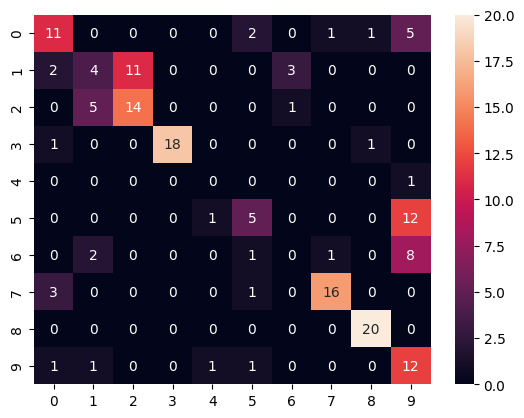

In [69]:
sns.heatmap(confusion_matrix(test_orb_labels, testLabels_pred), annot = True)

# Classification using KNN

### Train Data

In [70]:
X = np.array(np.dot(im_features, im_features.T), np.float32)
y = np.array(orb_labels)

### Model Training

In [71]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

### Save Model

In [72]:
# Save your model or results
joblib.dump(clf, 'models/orb_knn.pkl')

['models/orb_knn.pkl']

### Load Model

In [73]:
# Load your model or results
#clf = joblib.load('models/orb_nb.pkl')

### Model Testing

In [74]:
testLabels_pred = clf.predict(np.dot(test_im_features, im_features.T))

In [75]:
print(classification_report(test_orb_labels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       0.71      0.75      0.73        20
       00002       0.89      0.85      0.87        20
       00003       0.86      0.95      0.90        20
       00004       0.95      1.00      0.98        20
       00005       0.00      0.00      0.00         1
       00006       0.52      0.72      0.60        18
       00007       1.00      0.17      0.29        12
       00008       0.90      0.90      0.90        20
       00009       0.95      1.00      0.98        20
       00010       0.58      0.44      0.50        16

    accuracy                           0.78       167
   macro avg       0.74      0.68      0.67       167
weighted avg       0.82      0.78      0.78       167



<AxesSubplot:>

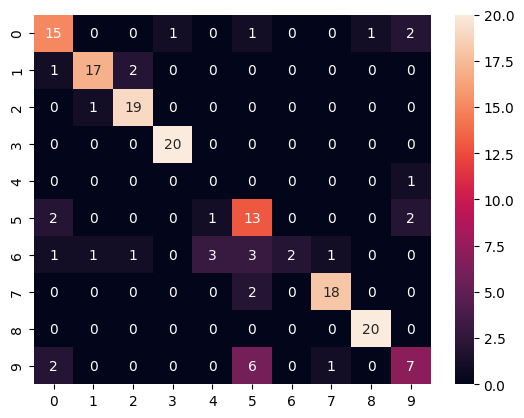

In [76]:
sns.heatmap(confusion_matrix(test_orb_labels, testLabels_pred), annot = True)

# Classification using Random Forest

### Train Data

In [77]:
X = np.array(np.dot(im_features, im_features.T), np.float32)
y = np.array(orb_labels)

### Model Training

In [78]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

### Save Model

In [79]:
# Save your model or results
joblib.dump(clf, 'models/orb_rf.pkl')

['models/orb_rf.pkl']

### Load Model

In [80]:
# Load your model or results
#clf = joblib.load('models/orb_nb.pkl')

### Model Testing

In [81]:
testLabels_pred = clf.predict(np.dot(test_im_features, im_features.T))

In [82]:
print(classification_report(test_orb_labels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       0.77      0.50      0.61        20
       00002       0.67      0.60      0.63        20
       00003       0.70      0.80      0.74        20
       00004       0.95      0.90      0.92        20
       00005       0.00      0.00      0.00         1
       00006       0.36      1.00      0.53        18
       00007       0.00      0.00      0.00        12
       00008       0.90      0.90      0.90        20
       00009       0.83      1.00      0.91        20
       00010       0.00      0.00      0.00        16

    accuracy                           0.67       167
   macro avg       0.52      0.57      0.52       167
weighted avg       0.62      0.67      0.62       167



/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

<AxesSubplot:>

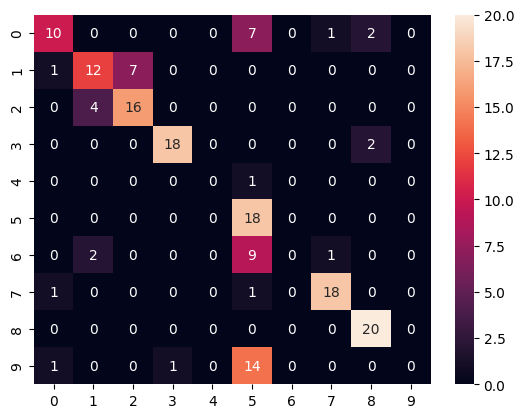

In [83]:
sns.heatmap(confusion_matrix(test_orb_labels, testLabels_pred), annot = True)

# Classification using Logistic Regression

### Train Data

In [84]:
X = np.array(np.dot(im_features, im_features.T), np.float32)
y = np.array(orb_labels)

### Model Training

In [85]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X, y)

/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=0)

### Save Model

In [86]:
# Save your model or results
joblib.dump(clf, 'models/orb_lr.pkl')

['models/orb_lr.pkl']

### Load Model

In [87]:
# Load your model or results
#clf = joblib.load('models/orb_nb.pkl')

### Model Testing

In [88]:
testLabels_pred = clf.predict(np.dot(test_im_features, im_features.T))

In [89]:
print(classification_report(test_orb_labels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       0.89      0.85      0.87        20
       00002       1.00      0.70      0.82        20
       00003       0.80      1.00      0.89        20
       00004       1.00      1.00      1.00        20
       00005       0.00      0.00      0.00         1
       00006       0.56      0.78      0.65        18
       00007       0.89      0.67      0.76        12
       00008       0.95      1.00      0.98        20
       00009       1.00      1.00      1.00        20
       00010       0.57      0.50      0.53        16

    accuracy                           0.84       167
   macro avg       0.77      0.75      0.75       167
weighted avg       0.86      0.84      0.84       167



/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

<AxesSubplot:>

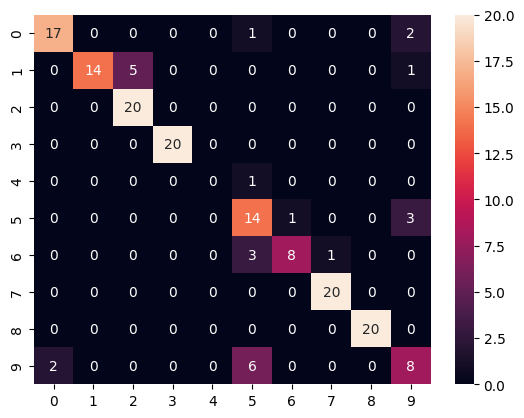

In [90]:
sns.heatmap(confusion_matrix(test_orb_labels, testLabels_pred), annot = True)